In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
from math import factorial
import strawberryfields as sf
from strawberryfields.backends.states import BaseBosonicState

from bosonicplus.states.coherent import gen_fock_coherent, gen_fock_superpos_coherent
from bosonicplus.states.wigner import Gauss
from bosonicplus.base import State

from bosonicplus.plotting import plot_wig

import matplotlib.pyplot as plt

from bosonicplus.fidelity import fidelity_bosonic, fidelity_with_wigner

In [2]:
def get_wigner_fast(state, k, x = None, p = None, MP=False):
        """
        Obtain the (single mode) Wigner function on a grid of phase space points
        """
        if x is None:
            x = np.linspace(-10,10,200)
        if p is None:
            p = x
            
        if state.num_modes != 1:
            raise ValueError('State has multiple modes, please specify indices.')
        W = 0
        if len(state.covs) == 1:
            for i in range(len(state.weights)):
                if i < k:
                    W += state.weights[i] * Gauss(state.covs, state.means[i], x, p, MP)/state.probability
                else:
                    W += np.real(state.weights[i] * Gauss(state.covs, state.means[i], x, p, MP)/state.probability)
                
        else:
            print('Else.')
            for i, mu in enumerate(state.means):
                W += state.weights[i] * Gauss(state.covs[i], mu, x, p, MP)/state.probability
        return W

In [3]:
def fc(state1, state2):
    """NEW FIDELITY FUNCTION FOR CALCULATING FIDELITY OF WIGNER AS SUM OF GAUSSIANS
    WHERE THE REAL PARTS OF THE CROSS TERMS ARE USED. NEED TO SOLVE COS*GAUSS INTEGRAL
    
    Calculate fidelity between two states in coherent representation 
    i.e. there is only one covariance matrix, but many weights and means.
    
    Args:
        state1 (bosonicplus.base.State):
        state2 (bosonicplus.base.State):
        
    Returns:
        fidelity (float): fidelity of state1 with state2, assuming one of them is pure
    """
    
    #Equal number of modes check
    if state1.num_modes != state2.num_modes:
        raise ValueError('Number of modes is not the same in both states.')

    N = state1.num_modes

    #The number of weights that are treated "normally", where the remainder of the weights must recieve special treatment
    k1 = state1.num_k
    k2 = state2.num_k

    weights1 = state1.weights
    weights2 = state2.weights
    
    deltas = state1.means[:,np.newaxis,:] - state2.means[np.newaxis,:,:]

    covsum = state1.covs + state2.covs #covs are the same shape, so no broadcasting needed
    
    covsum_inv = np.linalg.inv(covsum)
    
    exp_arg = np.einsum('...j,...jk,...k', deltas, covsum_inv, deltas)

    weighted_exp = weights1[:,np.newaxis] * weights2[np.newaxis,:] 

    weighted_exp_special = weights1[k1:,np.newaxis] * np.conjugate(weights2[np.newaxis,k2:])
    #sf.hbar ** N* np.sqrt( np.linalg.det(covsum)) 
                
    
    fidelity = 0    
    fidelity += np.sum(weighted_exp[0:k1,0:k2])
    fidelity += np.sum(weighted_exp[0:k1,k2:]).real
    fidelity += np.sum(weighted_exp[k1:,0:k2]).real
    fidelity += 0.5*np.sum(weighted_exp[k1:,k2:]).real
    fidelity += 0.5*np.sum(weighted_exp_special).real
    
    #fidelity = math.fsum(weighted_exp.reshape(len(state1.weights())*len(state2.weights())))
    
    return fidelity


In [4]:
x = np.linspace(-10,10,200)
n = 20

In [5]:
#Make s1 with (n+1)**2 Gaussians
m, c, w = gen_fock_coherent(n, 1e-5)
s1 = State(1)
s1.update_data([m,c,w])
print('No of Gaussian in Wigner rep: ', len(w))
print('Norm', np.sum(w))
W1 = s1.get_wigner(x,x)

No of Gaussian in Wigner rep:  441
Norm (1-6.938893903907228e-18j)


In [6]:
#Make s2 with around (n+1)**2 /2 Gaussians 

m, c, w, k = gen_fock_coherent(n,1e-5,fast =True)

print('No of Gaussians in fast Wigner rep', len(w))
print(f'No of normal Gaussians, {k}')
print('Norm', np.sum(w))
print('Norm of real parts', np.sum(w.real))
s2 = State(1)
s2.update_data([m,c,w], k=k)
W2 = s2.get_wigner(x,x)
W2fast = get_wigner_fast(s2,k,x,x)

No of Gaussians in fast Wigner rep 231
No of normal Gaussians, 21
Norm (1+0.4180800433237765j)
Norm of real parts 1.0


max imag of W2: 0.11242745702836432
max imag of W2fast: 0.0


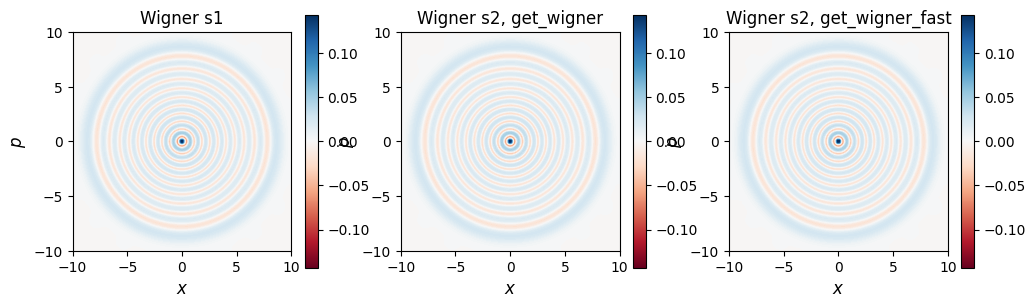

In [7]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
plot_wig(axes[0], W1, x,x)
axes[0].set_title('Wigner s1')
plot_wig(axes[1], W2,x,x)
axes[1].set_title('Wigner s2, get_wigner')
plot_wig(axes[2], W2fast,x,x)
axes[2].set_title('Wigner s2, get_wigner_fast')
print('max imag of W2:', np.max(W2.imag))
print('max imag of W2fast:', np.max(W2fast.imag))
plt.show()

In [8]:
#Normal fidelity functions no longer work for fast Wigner

print('Purity s1', fidelity_bosonic(s1,s1))
print('Purity s1 with wigner', fidelity_with_wigner(W1,W1,x,x))


print('Purity of s2 with normal fid fun', fidelity_bosonic(s2,s2))

print('Fidelity of s2 to s1, normal fid fun', fidelity_bosonic(s2,s1))

print('Purity of s2 with wigner', fidelity_with_wigner(W2fast, W2fast,x,x))

print('-'*100)

print('Purity s1, new fid fun', fc(s1,s1))
print('Purity of s2, new fid fun', fc(s2,s2))
print('Fidelity of s2 to s1, new fid fun', fc(s2,s1))


Purity s1 (0.9999999999999996+1.1006557874859186e-17j)
Purity s1 with wigner (0.9999941058311925+1.7943944725961534e-18j)
Purity of s2 with normal fid fun (0.07151964719231038-0.07246875492887157j)
Fidelity of s2 to s1, normal fid fun (0.8512152934966841-0.35587612678295494j)
Purity of s2 with wigner (0.9999941058311925+0j)
----------------------------------------------------------------------------------------------------
Purity s1, new fid fun (1-6.938893903907228e-18j)
Purity of s2, new fid fun (1+0j)
Fidelity of s2 to s1, new fid fun (1+2.960558821666091e-18j)


In [9]:
from time import time
t0 = time()
fidelity_bosonic(s1,s1)
t1 = time()
told = t1-t0


t0 = time()
fc(s2,s2)
t1 = time()
tnew = t1-t0
print('time of old fidelity calc', told)
print('time of new fideility calc', tnew)
print('told/tnew', told/tnew)

time of old fidelity calc 0.015876054763793945
time of new fideility calc 0.0029709339141845703
told/tnew 5.343792633015007


## Fock superpositions (GKP state)

In [10]:
from bosonicplus.states.gkp_squeezing import gkp_nonlinear_squeezing_operator
n = 10

rho = gkp_nonlinear_squeezing_operator(n)

w, v = np.linalg.eigh(rho)
    
coeffs = v[:,0] #eigs always sorted from lowest to highest eigenvalue, choose lowest

In [11]:
m,c,w=gen_fock_superpos_coherent(coeffs,1e-3)
gkp1 = State(1)
gkp1.update_data([m,c,w])
Wgkp1 = gkp1.get_wigner(x,x)
print(len(w))

121


In [12]:
m,c,w,k=gen_fock_superpos_coherent(coeffs,1e-3,fast=True)
gkp2 = State(1)
gkp2.update_data([m,c,w], k=k)


Wgkp2 = gkp2.get_wigner(x,x)
Wgkp2fast = get_wigner_fast(gkp2,k,x,x)

max imag of Wgkp2: 0.2067938583768946
max imag of Wgkp2fast: 0.0


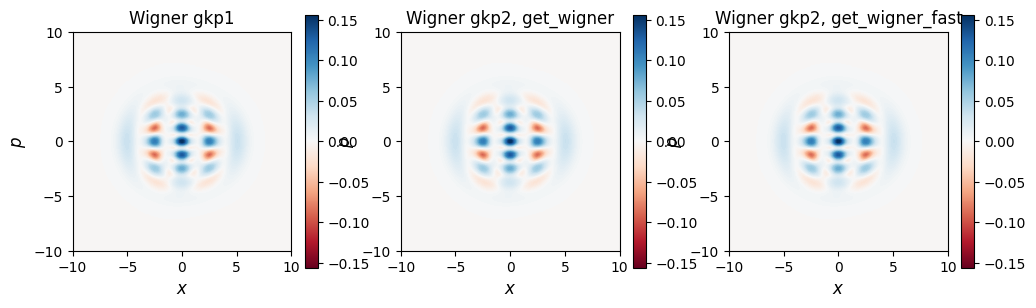

In [13]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
plot_wig(axes[0], Wgkp1, x,x)
axes[0].set_title('Wigner gkp1')
plot_wig(axes[1], Wgkp2,x,x)
axes[1].set_title('Wigner gkp2, get_wigner')
plot_wig(axes[2], Wgkp2fast,x,x)
axes[2].set_title('Wigner gkp2, get_wigner_fast')
print('max imag of Wgkp2:', np.max(Wgkp2.imag))
print('max imag of Wgkp2fast:', np.max(Wgkp2fast.imag))
plt.show()

In [14]:
#Fidelity function tests

print('Purity s1', fidelity_bosonic(gkp1,gkp1))
print('Purity s1 with wigner', fidelity_with_wigner(Wgkp1,Wgkp1,x,x))


print('Purity of s2 with normal fid fun', fidelity_bosonic(gkp2,gkp2))

print('Fidelity of s2 to s1, normal fid fun', fidelity_bosonic(gkp1,gkp2))

print('Purity of s2 with wigner', fidelity_with_wigner(Wgkp2fast, Wgkp2fast,x,x))

print('-'*100)

print('Purity s1, new fid fun', fc(gkp1,gkp1))
print('Purity of s2, new fid fun', fc(gkp2,gkp2))
print('Fidelity of s2 to s1, new fid fun', fc(gkp2,gkp1))


Purity s1 (1.0000000000000087+1.582067810090846e-15j)
Purity s1 with wigner (0.9999999999999651+2.4883202402936292e-17j)
Purity of s2 with normal fid fun (-1.6188578858406755-5.049594966146029j)
Fidelity of s2 to s1, normal fid fun (0.5917794524630439+0.5452767595014774j)
Purity of s2 with wigner (0.9999999999999634+0j)
----------------------------------------------------------------------------------------------------
Purity s1, new fid fun (1.0000000000000044+1.4988010832439613e-15j)
Purity of s2, new fid fun (0.9999999999999822+0j)
Fidelity of s2 to s1, new fid fun (1.0000000000000036+7.598088824778415e-16j)
